In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:

1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps
- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis


# 1. RDD and DataFrame APIs
In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data. DataFrames allow developers to impose a structure on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very first notebook of the CLOUDS course. The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">
<b>Question 1.</b> Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: {}s".format(time.time() - time_start))
print(words.take(5))

Runtime: 1240.2871398925781s
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: {}s".format(time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 94.57860517501831s


## Comments¶
The DataFrame approach took 128.5 seconds, while the RDD approach took 210.5 seconds. The DataFrame approach is faster because of the structure that is imposed on the data when it is read which allows certain operations to be optimized.

# 2. Analysis of flight data using the DataFrame API and SparkSQL
## Use case
In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the src_airport (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The departure_time feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:
- Using the RDD abstraction
- Using the DataFrame abstraction.

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD cleaned_data is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD. Please note that, package com.databricks.spark.csv can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.

DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file
To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with com.databricks.spark.csv, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are not as expected. For example, we expect that CRSDepTime to be of interger type. The type and the name of each column can be modified using function withColumn and withColumnRename respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function describe (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD
Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.

In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns


sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [7]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples
Using the contructed DataFrame, we can answer some simple questions:

- How many night flights do we have in our data?
- How many night flights per unique carrier?
NOTE: We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer.

<b>NOTE:</b> finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data.

Basic queries:
- How many unique origin airports?
- How many unique destination airports?
- How many carriers?
- How many flights that have a scheduled departure time later than 18h00?

Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "the more flights in an airport, the higher the probability of delay".
- How many flights in each month of the year?
- Is there any relationship between the number of flights and the days of week?
- How many flights in different days of months and in different hours of days?
- Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
- Which are the top 20 busiest carriers?

Statistics on the fraction of delayed flights
- What is the percentage of delayed flights (over total flights) for different hours of the day?
- Which hours of the day are characterized by the longest flight delay?
- What are the fluctuation of the percentage of delayed flights over different time granularities?
- What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
- What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries
### Question 2.1
<div class="alert alert-block alert-info">
How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

In [10]:
srcAirportCount = df.groupBy("src_airport").count().count()
print("Count of source airports:")
print(srcAirportCount)
destAirportCount = df.groupBy("dest_airport").count().count()
print("Count of destination airports:")
print(destAirportCount)

Count of source airports:
224
Count of destination airports:
225


### Comments
From our query, we have 224 origin airports and 225 destination airports. It is strange that there is a difference of 1 between these two counts, however this could be because of an error in the input data. Alternatively there could just be an airport where there are no outgoing planes.

### Question 2.2
<div class="alert alert-block alert-info">
How many unique carriers are present in the data?

In [11]:
uniqueCarrierCount = df.groupBy("carrier").count().count()
print("Count of unique carriers:")
print(uniqueCarrierCount)

Count of unique carriers:
10


### Question 2.3
<div class="alert alert-block alert-info">
- How many night flights (that is, flights departing later than 6pm or earlier than 6am)?
- What is the percentage of night flights over the total volume of flights


NOTE: Here we're using a more refined definition of what is a night flight, than in our earlier examples.

In [12]:
nightFlightCount = df.filter((df['scheduled_departure_time'] > 1800) | (df['scheduled_departure_time'] < 600)).count()
print("Number of night flights")
print(nightFlightCount)
totalFlights = df.count()
print("Total number of flights")
print(totalFlights)
print("Percentage of night flights")
print(nightFlightCount*100/totalFlights)

Number of night flights
1121918
Total number of flights
5180048
Percentage of night flights
21.658447952605844


## Question 3: Flight volume statistics
### Question 3.1
<div class="alert alert-block alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure. 
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.

+-----+------+
|month| count|
+-----+------+
|    1|423861|
|    2|386954|
|    3|435516|
|    4|420995|
|    5|436432|
|    6|426490|
|    7|443736|
|    8|451086|
|    9|430861|
|   10|449369|
|   11|428227|
|   12|446521|
+-----+------+

None


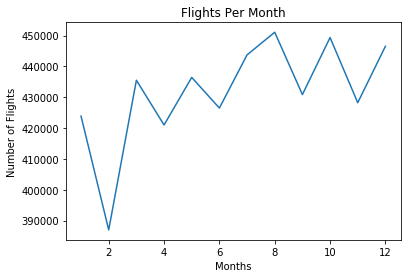

In [13]:
import matplotlib.pyplot as plt
flightsPerMonth = df.groupBy("month").count().orderBy('month', ascending=1)
print(flightsPerMonth.show())
flightsPerMonth = df.groupBy("month").count().orderBy('month', ascending=1).collect()
listOfMonths = [month[0] for month in flightsPerMonth]
countOfFlights = [month[1] for month in flightsPerMonth]

plt.plot(listOfMonths,countOfFlights)
plt.title("Flights Per Month")
plt.xlabel("Months")
plt.ylabel("Number of Flights")
plt.show()

### Comments
From the graph we see that August, October, and December have the highest flight volumes. Because of this, these months might experience more delays than in February (the month with the lowest number of flights), which is something worth looking into further. However, it's important to note that there are only 28 days in February, so just looking at the raw count of flights (instead of dividing it by the number of days in each month) could be misleading. We see less pronounced, but similar effects of less flights on the months with only 30 days vs 31, with the exception of January, which is similar to a 30-day month, perhaps because of reduced flights on New Years Eve.

### Question 3.2:
<div class="alert alert-block alert-info">
Is there any relationship between the number of flights and the days of the week? Plot a bar chart and interpret the figure. 


<b>NOTE:</b> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year). 

By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+

None
listOfWeekdays
[1, 2, 3, 4, 5, 6, 7]
countOfFlights
[754636, 756532, 756864, 751537, 751531, 695245, 713703]


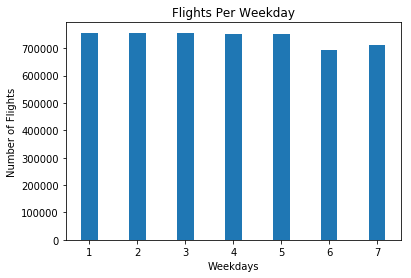

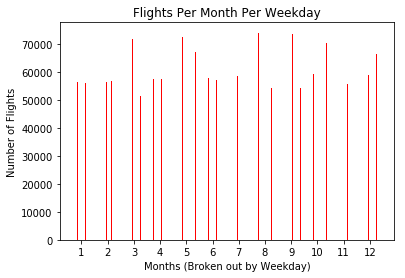

In [14]:
flightsPerWeekday = df.groupBy("day_of_week").count().orderBy('day_of_week', ascending=1)
print(flightsPerWeekday.show())
flightsPerWeekday = df.groupBy("day_of_week").count().orderBy('day_of_week', ascending=1).collect()
listOfWeekdays = [day[0] for day in flightsPerWeekday]
countOfFlights = [day[1] for day in flightsPerWeekday]
print("listOfWeekdays")
print(listOfWeekdays)
print("countOfFlights")
print(countOfFlights)

fig, ax = plt.subplots()
width = 0.35
counts = ax.bar(listOfWeekdays, countOfFlights, width)
ax.set_title("Flights Per Weekday")
ax.set_xlabel("Weekdays")
ax.set_ylabel("Number of Flights")
plt.show()

monthlyCounts = []
for month in range(1,13):
    monthlyCounts.append(df[df.month == month].groupBy("day_of_week").count().orderBy('day_of_week', ascending=1).collect())

fig, ax = plt.subplots()

width = 0.1
monthOffset = 10
for month in range(1,13):
    listOfWeekdays = [day[0] for day in monthlyCounts[month-1]]
    countOfFlights = [day[1] for day in monthlyCounts[month-1]]
    fullListOfWeekdays = [newPos + (month-1)*monthOffset for newPos in listOfWeekdays]
    counts = ax.bar(fullListOfWeekdays, countOfFlights, width, label=month,color='r')


ax.set_xticks([3.5 + monthOffset*p for p in range(12)])
xticks = range(1,13)
ax.set_xticklabels(xticks)

ax.set_title("Flights Per Month Per Weekday")
ax.set_xlabel("Months (Broken out by Weekday)")
ax.set_ylabel("Number of Flights")
plt.show()

### Comments
Note: We are assuming the week starts off with Monday = 1, going to Sunday = 7.<br>
From the first graph (aggregated by day of the week), we see that Saturday and Sunday have the fewest flights.<br>
However, when looking at the data further broken down by month, we see that the trend of decreased Saturday/Sunday flights is not reflected on a monthly basis. There is no clear trend for all the months. For example, in January we see that Sunday has the second highest number of flights. Similarly, in October we see Sunday and Saturday have the second and third highest number of flights respectively.

### Question 3.3:
<div class="alert alert-block alert-info">
How many flights in different days of months and in different hours of days? 

<b>NOTE:</b> Similarly to the previous note, you need to compute both global statistcs and monthly statistics. 

Plot bar charts, and interpret your figures.

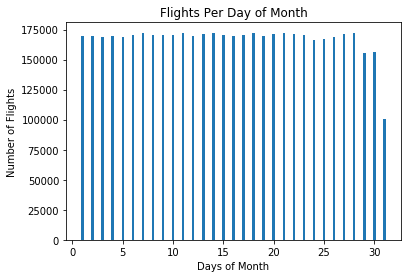

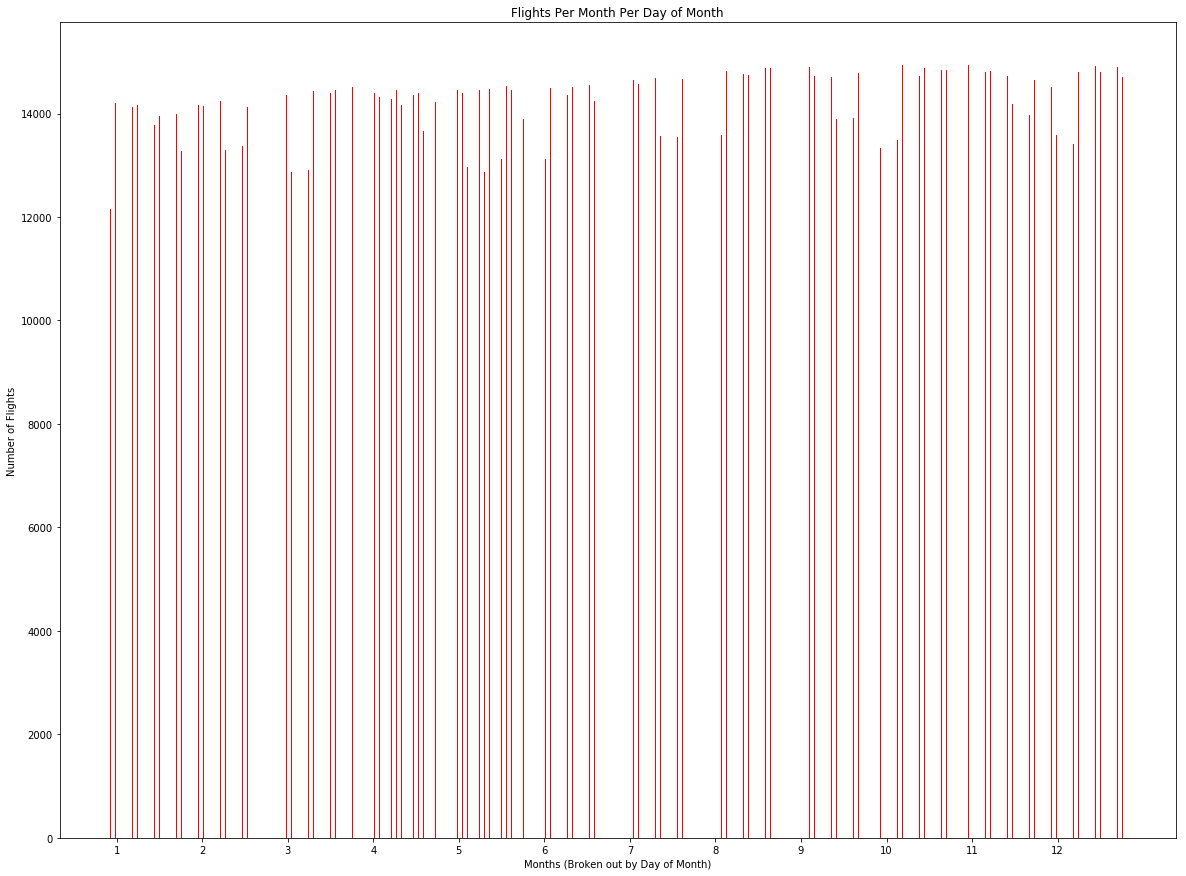

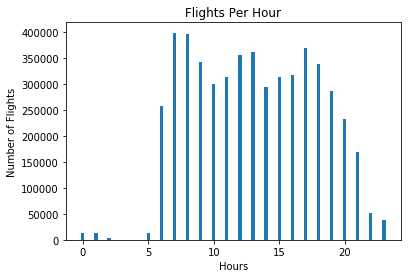

In [ ]:
import math
flightsPerDayOfMonth = df.groupby("day_of_month").count().orderBy('day_of_month', ascending=1).collect()

listOfDaysInMonth = [month[0] for month in flightsPerDayOfMonth]
countOfFlightsMonthly = [month[1] for month in flightsPerDayOfMonth]


## FIRST GRAPH
fig, ax = plt.subplots()
width = 0.25
counts = ax.bar(listOfDaysInMonth, countOfFlightsMonthly, width)
ax.set_title("Flights Per Day of Month")
ax.set_xlabel("Days of Month")
ax.set_ylabel("Number of Flights")
plt.show()


## 2ND GRAPH
monthlyCounts = []
for month in range(1,13):
    monthlyCounts.append(df[df.month == month].groupBy("day_of_month").count().orderBy('day_of_month', ascending=1).collect())

fig, ax = plt.subplots()
width = 0.1
monthOffset = 35
for month in range(1,13):
    listOfDays = [day[0] for day in monthlyCounts[month-1]]
    countOfFlights = [day[1] for day in monthlyCounts[month-1]]
    fullListOfDays = [newPos + (month-1)*monthOffset for newPos in listOfDays]
    counts = ax.bar(fullListOfDays, countOfFlights, width, label=month,color='r')


ax.set_xticks([3.5 + monthOffset*p for p in range(12)])
xticks = range(1,13)
ax.set_xticklabels(xticks)

ax.set_title("Flights Per Month Per Day of Month")
ax.set_xlabel("Months (Broken out by Day of Month)")
ax.set_ylabel("Number of Flights")
fig.set_size_inches(20, 15)
plt.show()


## 3RD GRAPH 
flightsPerHour = df.groupBy("scheduled_departure_time").count().orderBy('scheduled_departure_time', ascending=1).collect()

listOfHours = list(range(0,24))
countOfFlightsPerHour = [0] * 24
# here need to sum these up according to the hour that is /100 from 0th elt
listOfTimes = [math.floor(hour[0]/100) for hour in flightsPerHour]
listOfFlightsByTime = [hour[1] for hour in flightsPerHour]


for idx, elt in enumerate(listOfTimes):
    if elt == 24:
        elt = 0
        
    countOfFlightsPerHour[elt] += listOfFlightsByTime[idx]
    

fig, ax = plt.subplots()
width = 0.25
counts = ax.bar(listOfHours, countOfFlightsPerHour, width)
ax.set_title("Flights Per Hour")
ax.set_xlabel("Hours")
ax.set_ylabel("Number of Flights")
plt.show()

## 4th GRAPH
hourlyDF1 = df.withColumn("scheduled_departure_time", (df.scheduled_departure_time/100).cast('int')) # NOTE: here hourlyDF1 uses sched dep time, to be same as before, different than below

monthlyCounts = []
for month in range(1,13):
    monthlyCounts.append(hourlyDF1[hourlyDF1.month == month].groupBy("scheduled_departure_time").count().orderBy('scheduled_departure_time', ascending=1).collect())

fig, ax = plt.subplots()
width = 0.1
monthOffset = 30
for month in range(1,13):
    listOfDays = [day[0] for day in monthlyCounts[month-1]]
    countOfFlights = [day[1] for day in monthlyCounts[month-1]]
    fullListOfDays = [newPos + (month-1)*monthOffset for newPos in listOfDays]
    counts = ax.bar(fullListOfDays, countOfFlights, width, label=month,color='r')


ax.set_xticks([3.5 + monthOffset*p for p in range(12)])
xticks = range(1,13)
ax.set_xticklabels(xticks)

ax.set_title("Flights Per Month Per Hour of Day")
ax.set_xlabel("Months (Broken out by Hour of Day)")
ax.set_ylabel("Number of Flights")
fig.set_size_inches(20, 15)
plt.show()

### Comments
In the figure showing number of flights broken out by day, there is not a major difference between days 1-28. However, since not all months have more than 28 days, there is a drop off starting from the 29th and dropping off even further on the 31st.
When breaking it out by months, we see that there is a consistent cyclical trend which likely correlates to the higher number of flights during the business week compared to the weekend. We also see a sharp dip for a few days in the end of November and December, which must be because of the lower number of flights on the days of Thanksgiving and Christmas. In December especially, we actually see an increase in flights before/after the slow period.

When looking at the number of flights per hour, we see that there are very few in the early hours of the morning from 12AM to 5AM, but it then rises with the highest number of flights from 7 to 8AM. This is likely due to the number of business travelers who need to take these early flights in order to land at the start of the business day. We see very similar patterns when breaking out the flights per hour by month.

### Question 3.4:
<div class="alert alert-block alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.

In [ ]:
print("Busiest by # of Outbound Flights")
srcDF = df.groupBy("src_airport").count().orderBy('count', ascending=0)
srcDF.show()
srcDF = srcDF.withColumnRenamed("src_airport","airport")
srcDF = srcDF.withColumnRenamed("count","src_count")

print("Busiest by # of Inbound Flights")
destDF = df.groupBy("dest_airport").count().orderBy('count', ascending=0)
destDF.show()
destDF = destDF.withColumnRenamed("dest_airport","airport")

print("Busiest by # of Total Flights")
totalDF = srcDF.join(destDF,"airport")

totalDF = totalDF.withColumn("count",totalDF["src_count"] + totalDF["count"]).orderBy('count',ascending=0)
totalDF.select(["airport","count"]).show()

### Question 3.5:
<div class="alert alert-block alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.

In [ ]:
df.groupBy("carrier").count().orderBy('count', ascending=0).show()

## Question 4: Flight volume statistics
### Question 4.1
<div class="alert alert-block alert-info">
What is the percentage of delayed flights for different hours of the day? Plot a bar chart and interpret the figure. <p>IMPORTANT! A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

In [ ]:
df.groupBy("arrival_delay").count().collect()
listOfHours = list(range(0,24))
countOfScheduledFlightsPerHour = [0] * 24
countOfDelayedFlightsPerHour = [0] * 24



hourlyDF = df.withColumn("scheduled_departure_time", (df.scheduled_departure_time/100).cast("int"))

delayedArrivals = hourlyDF[hourlyDF.arrival_delay > 15].groupBy("scheduled_departure_time").count()

schedArrivals = hourlyDF.groupBy("scheduled_departure_time").count()

listOfScheduledArrivals = schedArrivals.collect()
listOfDelayedArrivals = delayedArrivals.collect()
# can iterate to get each column, 

# here need to sum these up according to the hour that is /100 from 0th elt
listOfScheduledTimes = [hour[0] for hour in listOfScheduledArrivals] # this is the time
listOfScheduledArrivalsByTime = [hour[1] for hour in listOfScheduledArrivals] # this is the count at that time

listOfDelayedTimes = [hour[0] for hour in listOfDelayedArrivals]
listOfDelayedArrivalsByTime = [hour[1] for hour in listOfDelayedArrivals]

#Scheduled
for idx, elt in enumerate(listOfScheduledTimes):
    if elt == 24:
        elt = 0
        
    countOfScheduledFlightsPerHour[elt] += listOfScheduledArrivalsByTime[idx] 

#Delayed
for idx, elt in enumerate(listOfDelayedTimes):
    if elt == 24:
        elt = 0
        
    countOfDelayedFlightsPerHour[elt] += listOfDelayedArrivalsByTime[idx]

percentageOfDelayedFlights = [0] * 24
for idx in range(24):
    percentageOfDelayedFlights[idx] = countOfDelayedFlightsPerHour[idx]*100/countOfScheduledFlightsPerHour[idx]

fig, ax = plt.subplots()
counts = ax.bar(listOfHours, percentageOfDelayedFlights)
ax.set_title("Percentage of Delayed Flights by Hour")
ax.set_xlabel("Hours")
ax.set_ylabel("Percent of Flights")
plt.show()

### Comments
The percentage of delayed flights by hour seems to reset around 4 AM, where the chance of being delayed is the lowest. From then, the percentage increases until 8 PM, where it then drops off until 4 AM. This is not surprising given that the number of flights from 12 AM to 4 AM is low, giving airline workers a chance to catch up, whereas as airports get busier and flights increase, the delays increase as well. In addition, one delay causes a chain reaction that affects all flights following it, causing further delays, so it makes sense that the percentage of delays increases steadily over the course of the day.

### Question 4.2
<div class="alert alert-block alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!
Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too) Plot a Bar chart and explain it.

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

NOTE: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [ ]:
listOfMeanDelay = [0]*24
sumOfDelayedArrivals = [0]*24
countList = [0]*24 #temp value of counts, to divide to get mean

listOfScheduledArrivalsAndDelays = df.groupBy("scheduled_departure_time","arrival_delay").count().collect()
listOfScheduledTimes = [math.floor(hour[0]/100) for hour in listOfScheduledArrivalsAndDelays]
minutesInDelayedArrival = [hour[1] for hour in listOfScheduledArrivalsAndDelays]
countOfDelayedArrivals = [hour[2] for hour in listOfScheduledArrivalsAndDelays]


for idx, elt in enumerate(listOfScheduledTimes):
    if elt == 24:
        elt = 0
    if minutesInDelayedArrival[idx] == None:
        minutesInDelayedArrival[idx] = 0
    countList[elt] += countOfDelayedArrivals[idx]
    sumOfDelayedArrivals[elt] += countOfDelayedArrivals[idx]*minutesInDelayedArrival[idx]
    
for idx in range(24):
    listOfMeanDelay[idx] = sumOfDelayedArrivals[idx]/countList[idx]

fig, ax = plt.subplots()
counts = ax.bar(listOfHours, listOfMeanDelay)
ax.set_title("Average Number of Minutes in Delayed Arrival Time by Hour")
ax.set_xlabel("Hours")
ax.set_ylabel("Average Minutes")
plt.show()

### Comments¶
The bar chart shows a similar pattern as seen in the percentage of delayed flights over 24 hours, in that it's minimized in the early hours of the morning and then steadily increases until the evening, at which point it starts dropping again. The biggest difference is the "negative delay" at 3-4 AM where flights on average depart a few minutes earlier than their scheduled time.

In [ ]:
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(listOfHours, percentageOfDelayedFlights, align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if listOfMeanDelay[i] < 0:
        color = 'lightgreen'
    elif listOfMeanDelay[i] < 2:
        color = 'green'
    elif listOfMeanDelay[i] < 4:
        color = 'yellow'
    elif listOfMeanDelay[i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.

### Question 4.3
<div class="alert alert-block alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.

In [ ]:
hourlyDF = df.withColumn("scheduled_departure_time", (df.scheduled_departure_time/100).cast('int'))

delayedArrivalsByMonth = hourlyDF[hourlyDF.arrival_delay > 15].groupBy("day_of_month").count()

schedArrivalsByMonth = hourlyDF.groupBy("day_of_month").count()

listOfScheduledArrivals = schedArrivalsByMonth.collect()
listOfDelayedArrivals = delayedArrivalsByMonth.collect()
# can iterate to get each column, 

listOfDays = list(range(1,32))
countOfScheduledFlightsPerDay = [0] * 31
countOfDelayedFlightsPerDay = [0] * 31

# here need to sum these up according to the hour that is /100 from 0th elt
listOfScheduledTimes = [day[0] for day in listOfScheduledArrivals] # this is the time
listOfScheduledArrivalsByTime = [day[1] for day in listOfScheduledArrivals] # this is the count at that time

listOfDelayedTimes = [day[0] for day in listOfDelayedArrivals]
listOfDelayedArrivalsByTime = [day[1] for day in listOfDelayedArrivals]

#Scheduled
for idx, elt in enumerate(listOfScheduledTimes):
    countOfScheduledFlightsPerDay[elt-1] += listOfScheduledArrivalsByTime[idx]

#Delayed
for idx, elt in enumerate(listOfDelayedTimes):
        
    countOfDelayedFlightsPerDay[elt-1] += listOfDelayedArrivalsByTime[idx]


percentageOfDelayedFlights = [0] * 31
for idx in range(31):
    percentageOfDelayedFlights[idx] = countOfDelayedFlightsPerDay[idx]*100/countOfScheduledFlightsPerDay[idx]

fig, ax = plt.subplots()
counts = ax.bar(listOfDays, percentageOfDelayedFlights)
ax.set_title("Percentage of Delayed Flights by Day")
ax.set_xlabel("Days")
ax.set_ylabel("Percent of Flights")
plt.show()

### Comments
There is a higher likelihood of being delayed at the end of each month, although at the very end and the beginning of each month, the likelihood is at its lowest.

### Question 4.4
<div class="alert alert-block alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.

In [ ]:
hourlyDF = df.withColumn("scheduled_departure_time", (df.scheduled_departure_time/100).cast('int'))

delayedArrivalsByWeek = hourlyDF[hourlyDF.arrival_delay > 15].groupBy("day_of_week").count()

schedArrivalsByWeek = hourlyDF.groupBy("day_of_week").count()

listOfScheduledArrivals = schedArrivalsByWeek.collect()
listOfDelayedArrivals = delayedArrivalsByWeek.collect()
# can iterate to get each column, 

listOfDays = list(range(1,8))
countOfScheduledFlightsPerDay = [0] * 7
countOfDelayedFlightsPerDay = [0] * 7

# here need to sum these up according to the hour that is /100 from 0th elt
listOfScheduledTimes = [day[0] for day in listOfScheduledArrivals] # this is the time
listOfScheduledArrivalsByTime = [day[1] for day in listOfScheduledArrivals] # this is the count at that time

listOfDelayedTimes = [day[0] for day in listOfDelayedArrivals]
listOfDelayedArrivalsByTime = [day[1] for day in listOfDelayedArrivals]

#Scheduled
for idx, elt in enumerate(listOfScheduledTimes):
    countOfScheduledFlightsPerDay[elt-1] += listOfScheduledArrivalsByTime[idx]

#Delayed
for idx, elt in enumerate(listOfDelayedTimes):
        
    countOfDelayedFlightsPerDay[elt-1] += listOfDelayedArrivalsByTime[idx]


percentageOfDelayedFlights = [0] * 7
for idx in range(7):
    percentageOfDelayedFlights[idx] = countOfDelayedFlightsPerDay[idx]*100/countOfScheduledFlightsPerDay[idx]

fig, ax = plt.subplots()
counts = ax.bar(listOfDays, percentageOfDelayedFlights)
ax.set_title("Percentage of Delayed Flights by Day")
ax.set_xlabel("Days")
ax.set_ylabel("Percent of Flights")
plt.show()

### Comments
Over the course of the week, the likelihood of delays is highest in the middle of the week (Wednesdays to Fridays), and lowest on weekends. This could be again related to the number of business flights, since there are more flights in the middle of the week and none over the weekend.

### Question 4.5
<div class="alert alert-block alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.

In [ ]:
hourlyDF = df.withColumn("scheduled_departure_time", (df.scheduled_departure_time/100).cast('int'))

delayedArrivalsByMonth = hourlyDF[hourlyDF.arrival_delay > 15].groupBy("month").count()

schedArrivalsByMonth = hourlyDF.groupBy("month").count()

listOfScheduledArrivals = schedArrivalsByMonth.collect()
listOfDelayedArrivals = delayedArrivalsByMonth.collect()
# can iterate to get each column

listOfMonths = list(range(1,13))
countOfScheduledFlightsPerMonth = [0] * 12
countOfDelayedFlightsPerMonth = [0] * 12

# here need to sum these up according to the hour that is /100 from 0th elt
listOfScheduledTimes = [day[0] for day in listOfScheduledArrivals] # this is the time
listOfScheduledArrivalsByTime = [day[1] for day in listOfScheduledArrivals] # this is the count at that time

listOfDelayedTimes = [day[0] for day in listOfDelayedArrivals]
listOfDelayedArrivalsByTime = [day[1] for day in listOfDelayedArrivals]

#Scheduled
for idx, elt in enumerate(listOfScheduledTimes):
    #print("elt")
    #print(elt)
    countOfScheduledFlightsPerMonth[elt-1] += listOfScheduledArrivalsByTime[idx]

#Delayed
for idx, elt in enumerate(listOfDelayedTimes):
        
    countOfDelayedFlightsPerMonth[elt-1] += listOfDelayedArrivalsByTime[idx]

percentageOfDelayedFlights = [0] * 12
for idx in range(12):
    percentageOfDelayedFlights[idx] = countOfDelayedFlightsPerMonth[idx]*100/countOfScheduledFlightsPerMonth[idx]

fig, ax = plt.subplots()
counts = ax.bar(listOfMonths, percentageOfDelayedFlights)
ax.set_title("Percentage of Delayed Flights by Month")
ax.set_xlabel("Months")
ax.set_ylabel("Percent of Flights")
plt.show()

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

### Comments
There are the most delays in January and February, whereas May and September had the least likelihood of being delayed. There is an increase of delays over the summer, perhaps due to the influx of summer vacation travelers. January and February likely had large delays due to inclement weather conditions. We do not have enough data to comment on French airplane delays, however we can speculate that in the US, May and September correspond with the end/beginning of the school year, so there are fewer flights in those months.

In [ ]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

In [ ]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-block alert-info">
What is the delay probability for the top 20 busiest airports? By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay. 

In [ ]:
#Setting up DF
totalDF = totalDF.select(["airport","count"])

srcDelayDF = df[df.arrival_delay>15].groupBy("src_airport").count()
srcDelayDF = srcDelayDF.withColumnRenamed("src_airport","airport")
srcDelayDF = srcDelayDF.withColumnRenamed("count","src_count")
destDelayDF = df[df.arrival_delay>15].groupBy("dest_airport").count()
destDelayDF = destDelayDF.withColumnRenamed("dest_airport","airport")

delayDF = srcDelayDF.join(destDelayDF,"airport")
delayDF = delayDF.withColumn("count",delayDF["src_count"] + delayDF["count"]).orderBy('count',ascending=0)
delayDF = delayDF.select(["airport","count"])
delayDF = delayDF.withColumnRenamed("count", "delayed_count")

delayRatioDF = totalDF.join(delayDF,"airport")
delayRatioDF = delayRatioDF.withColumn("delayed_count",delayRatioDF["delayed_count"] / delayRatioDF["count"])
delayRatioDF = delayRatioDF.withColumnRenamed("delayed_count", "delayed_ratio")
delayRatioDF = delayRatioDF.orderBy(["count"],ascending=0)

listOfAirportsAndDelays = delayRatioDF.collect()
listOfAirports = [airport[0] for airport in listOfAirportsAndDelays][:20]
listOfAirportCount = [airport[1] for airport in listOfAirportsAndDelays][:20]
listOfAirportDelays = [airport[2] for airport in listOfAirportsAndDelays][:20]

In [ ]:
#Plotting 
fig, ax1 = plt.subplots()

my_xticks = listOfAirports


x = list(range(20))

plt.xticks(x, my_xticks)
ax1.plot(x,listOfAirportCount, 'b-')

ax2 = ax1.twinx()
ax2.plot(x,listOfAirportDelays, 'r-')

ax1.set_xlabel('Airport')
ax1.set_ylabel('Number of Flights', color='b')
ax1.tick_params('y', colors='b')
ax2.set_ylabel('Ratio of Delays', color='r')
ax2.tick_params('y', colors='r')
plt.show()


### Comments
We see that there is no correlation in the number of flights and the ratio of delays, as we see at EWR, where they have fewer than 50% of the flights that ORD has, the percentage of delays is nevertheless almost double the percentage at ORD. Thus we can say that it likely has less to do with the busyness of the airport and more to do with external conditions related to the airport's efficiency.

### Question 4.7
<div class="alert alert-block alert-info">What is the percentage of delayed flights which belong to one of the top 20 busiest carriers? 

In [ ]:
carrierDF = df.groupBy("carrier").count().orderBy('count', ascending=0) 

delayedByCarrierDF = df[df.arrival_delay > 15].groupBy("carrier").count()
delayedByCarrierList = delayedByCarrierDF.collect()

carriersList = [carrier[0] for carrier in delayedByCarrierList]
pctDelayedList = [carrier[1] for carrier in delayedByCarrierList]


totalDelayed = df[df.arrival_delay > 15].count()
pctDelayedList = [point * 100 / totalDelayed for point in pctDelayedList]

fig, ax1 = plt.subplots()

my_xticks = carriersList

x = list(range(len(carriersList)))

plt.xticks(x, my_xticks)
ax1.plot(x,pctDelayedList, 'b-')

ax1.set_xlabel('Carrier')
ax1.set_ylabel('Percent Delayed', color='b')
ax1.tick_params('y', colors='b')
plt.show()

### Comments
We see very big differences between carriers, with DL and US having the highest percentage of delayed flights at 18%. Meanwhile, AS had only 2% of flights delayed and HP had just under 4%. Again, we do not see a correlation between carrier size and delays, since DL and US are not the top carriers, and HP is actually bigger than both DL and US.